100%|██████████| 9912422/9912422 [00:00<00:00, 66623578.41it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36138333.48it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19784618.32it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15968590.75it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

samples in training dataset:  60000


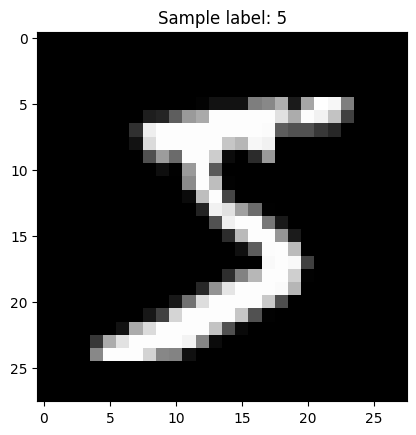

In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt
import torch

data_path = 'data'
mnist_train = datasets.MNIST(data_path,
                             train=True,
                             download=True)
mnist_validation = datasets.MNIST(data_path,
                                  train=False,
                                  download=True)

print("samples in training dataset: ", len(mnist_train))

image, label = mnist_train[0]
plt.imshow(image, cmap='gray')
plt.title(f"Sample label: {label}")
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
image_as_tensor = to_tensor(image)
print(image_as_tensor.shape)

torch.Size([1, 28, 28])


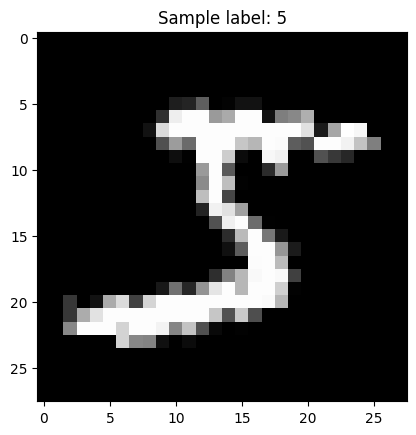

In [ ]:
# random rotation between 0 an 90 degrees
rotation = transforms.RandomRotation(90)
rotated = rotation(image_as_tensor)

def display_image(image, label):
    # permute required to transform back in the PIL format
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    plt.title(f"Sample label: {label}")
    plt.show()

display_image(rotated, label)

In [ ]:
tensor_mnist_train = datasets.MNIST(data_path,
                                    train=True,
                                    download=False,
                                    transform=transforms.ToTensor())

sample, label = tensor_mnist_train[0]
print(type(sample), sample.dtype, sample.shape)


<class 'torch.Tensor'> torch.float32 torch.Size([1, 28, 28])


In [ ]:
import numpy as np
print(f"image min: {np.array(image).min()}, image max: {np.array(image).max()}")
print(f"tensor min: {sample.min()}, tensor max: {sample.max()}")

image min: 0, image max: 255
tensor min: 0.0, tensor max: 1.0


In [ ]:
dataset = torch.stack([sample for sample, _ in tensor_mnist_train], dim=3)
print(dataset.shape)
means = dataset.view(1, -1).mean(dim=1)
stds = dataset.view(1, -1).std(dim=1)
print(means)
print(stds)
normalize = transforms.Normalize(means, stds)

torch.Size([1, 28, 28, 60000])
tensor([0.1307])
tensor([0.3081])


In [ ]:
transformed_mnist_train = datasets.MNIST(data_path, train=True,
                                         download=False,
                                         transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         normalize,]))

dataset = torch.stack([sample for sample, _ in transformed_mnist_train], dim=3)

# let's verify that the mean and standard deviation are now as we want them
means = dataset.view(1, -1).mean(dim=1)
stds = dataset.view(1, -1).std(dim=1)
print(f"mean: {means}")
print(f"std: {stds}")

mean: tensor([-1.2855e-07])
std: tensor([1.0000])


In [ ]:
class MNISTModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 512)
        self.fc2 = torch.nn.Linear(512, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # we have to flatten the samples that are 28x28
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = MNISTModel()

sample, label = transformed_mnist_train[0]

# prediction from untrained model
out = net(sample)
print("scores:", out)

# predicted class
pred = out.argmax(dim=1)
print("predicted class:", pred.item())
print("original label: ", label)

scores: tensor([[ 0.2304,  0.3923, -0.0926,  0.5928,  0.0877,  0.2560,  0.2800, -0.5860,
          0.0695, -0.0451]], grad_fn=<AddmmBackward0>)
predicted class: 3
original label:  5


In [ ]:
transformed_mnist_validation = datasets.MNIST(data_path, train=False,
                                              download=False,
                                              transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              normalize,]))  # same normalize as train

train_loader = torch.utils.data.DataLoader(transformed_mnist_train,
                                           batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_mnist_validation,
                                         batch_size=64,
                                         shuffle=False)


In [ ]:
learning_rate = 1e-2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# train
for epoch in range(epochs):
    for samples, labels in train_loader:
        outputs = net(samples)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch + 1}, Loss: {loss}")


Epoch: 1, Loss: 0.39319488406181335
Epoch: 2, Loss: 0.45465096831321716


In [ ]:
accuracy = 0.0
total = 0
for samples, labels in val_loader:
    outputs = net(samples)
    predictions = outputs.argmax(dim=1)
    total += samples.shape[0]
    accuracy += (predictions.type(labels.dtype) == labels).float().sum()
accuracy = accuracy / total

print(f"Accuracy: {accuracy}")

Accuracy: 0.9315000176429749


In [ ]:
learning_rate = 1e-2
epochs = 5
device = torch.device('cuda')
net = MNISTModel()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, scheduler, loss_fn):
    train_loss = 0.0
    total = 0
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = model(samples)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += samples.shape[0]
        train_loss += loss.sum().detach()
    train_loss /= total
    scheduler.step(train_loss)
    return train_loss.item()

def valid_epoch(model, val_loader, loss_fn):
    accuracy = 0.0
    validation_loss = 0.0
    total = 0
    for samples, labels in val_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = net(samples)
        loss = loss_fn(outputs, labels)
        predictions = outputs.argmax(dim=1)
        accuracy += (predictions.type(labels.dtype) == labels).float().sum()
        total += samples.shape[0]
        validation_loss += loss.sum()
    validation_loss /= total
    accuracy = accuracy / total
    return validation_loss.item(), accuracy.item()

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, scheduler, loss_fn)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(epoch, accuracy)

0 0.9136999845504761
1 0.9307000041007996
2 0.9399999976158142
3 0.9467999935150146
4 0.9506999850273132


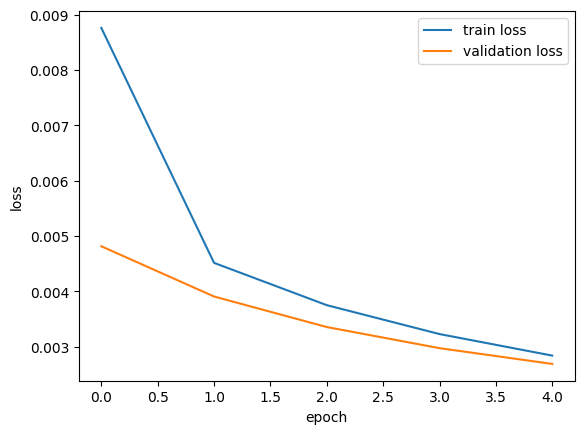

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

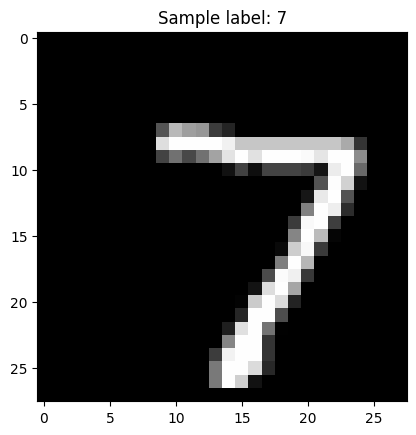

accuracy:  0.9506999850273132 accuracy after augmentation: 0.49289998412132263


In [ ]:
def shift_pixels(t):
    shift = 3
    return torch.roll(t, shift)

# let's see how the network generalizes
augmented_mnist_validation = datasets.MNIST(data_path, train=False,
                                              download=False,
                                              transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Lambda(shift_pixels),
                                              normalize,]))
augmented_val_loader = torch.utils.data.DataLoader(augmented_mnist_validation,
                                         batch_size=64,
                                         shuffle=False)

images, labels = augmented_mnist_validation[0]
display_image(images, labels)

val_loss_augmented, accuracy_augmented = valid_epoch(net, augmented_val_loader, loss_fn)

print("accuracy: ", accuracy, "accuracy after augmentation:", accuracy_augmented)